In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine,inspect, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
inspector = inspect(engine)
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

('2010-01-01',) ('2017-08-23',)


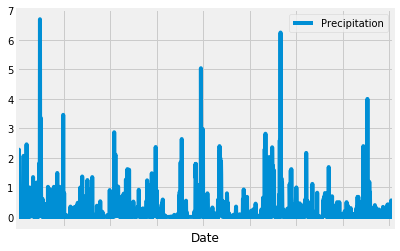

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
first=session.query(Measurement.date).order_by(Measurement.date).first()
last=session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(first,last)

# Calculate the date 1 year ago from the last data point in the database
last_date=dt.datetime.strptime(last[0],"%Y-%m-%d")
querydate = dt.date(last_date.year -1, last_date.month, last_date.day)

# Perform a query to retrieve the data and precipitation scores
prcp=session.query(Measurement.prcp,Measurement.date).\
filter(Measurement.date>=querydate).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df=pd.DataFrame(prcp,columns=['Precipitation','Date'])
prcp_df=prcp_df.dropna(how='any')
prcp_df.set_index('Date',inplace=True)

# Sort the dataframe by date
prcp_df=prcp_df.sort_values(by=['Date'])
prcp_df
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot()
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

plt.savefig("output/precipitation over year.png")
plt.show()


In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
# Design a query to show how many stations are available in this dataset?
session.query(Station.id).count()

9

In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station,func.count(Station.id)).\
filter(Station.station==Measurement.station).\
group_by(Measurement.station).\
order_by(func.count(Station.station).desc()).all()


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(Measurement.station,func.min(Measurement.tobs),func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
filter(Measurement.station == 'USC00519281').\
group_by(Measurement.station).all()

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

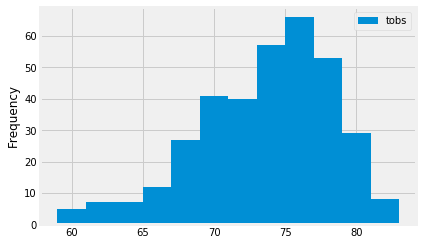

In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp=session.query(Measurement.date,Measurement.tobs).\
filter(Measurement.station=='USC00519281').\
filter(Measurement.date>=querydate).all()

temp_df=pd.DataFrame(temp,columns=['Date','Temp'])
temp_df = temp_df.sort_values(by='Date', ascending=True)
temp_df.set_index('Date', inplace=True)

plt.hist(temp_df['Temp'],bins=12,label='tobs')
plt.legend(loc='upper right')
plt.ylabel("Frequency")
plt.savefig("output/temperature observation of USC00519281.png")
plt.show()


In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [19]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

start_date='2011-02-28'
end_date='2011-03-05'
trip_temp=calc_temps(start_date,end_date)[0]
trip_temp

(61.0, 69.75510204081633, 75.0)

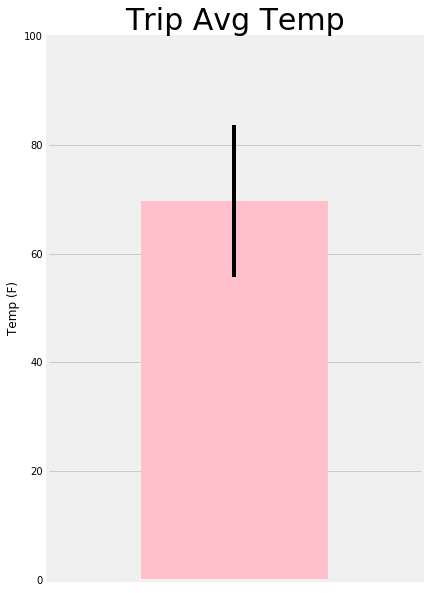

In [20]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip=pd.DataFrame([trip_temp],columns=['Min Temp','Avg Temp','Max Temp'])
ptp=trip['Max Temp']-trip['Min Temp']
avg=trip['Avg Temp']
avg.plot(kind='bar',figsize=(6,10), yerr=ptp,color='pink')
plt.title("Trip Avg Temp", fontsize=30)
plt.ylabel("Temp (F)")
plt.ylim(0,100)
plt.xticks([])
plt.grid(which='major',axis='y',linestyle='-')
plt.savefig("output/Trip Temperature.png")
plt.show()


In [21]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

session.query(Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation).\
filter(Station.station==Measurement.station).\
filter(Measurement.date>=start_date).\
filter(Measurement.date<=end_date).\
group_by(Measurement.station).\
order_by(Measurement.prcp.desc()).all()

[('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0)]

## Optional Challenge Assignment

# Temperature Analysis I

In [22]:
hawaii_june=session.query(Measurement.date,Measurement.tobs).filter(func.strftime("%m",Measurement.date)== '06').all()
hawaii_june_df=pd.DataFrame(hawaii_june,columns=['date','temperature'])
hawaii_june_df.sort_values(by='date')
hawaii_june_df=hawaii_june_df.set_index('date')
hawaii_june_df.describe()


,temperature
count,1700.000000
mean,74.944118
std,3.257417
min,64.000000
25%,73.000000
50%,75.000000
75%,77.000000
max,85.000000


In [23]:
hawaii_december=session.query(Measurement.date,Measurement.tobs).filter(func.strftime("%m",Measurement.date) =='12').all()
hawaii_december_df=pd.DataFrame(hawaii_december,columns=['date','temperature'])
hawaii_december_df.sort_values(by='date')
hawaii_december_df.set_index('date')
hawaii_december_df.describe()

,temperature
count,1517.000000
mean,71.041529
std,3.745920
min,56.000000
25%,69.000000
50%,71.000000
75%,74.000000
max,83.000000


In [24]:
 from scipy.stats import sem, ttest_ind
(t_stat, p) = ttest_ind(hawaii_june_df['temperature'],hawaii_december_df['temperature'], equal_var=False)
(t_stat,p)

(31.355036920962423, 4.193529835915755e-187)

# Temperature Analysis II

In [25]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [26]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`  
# Set the start and end date of the trip
# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings
# Loop through the list of %m-%d strings and calculate the normals for each date
s_date=dt.datetime.strptime(start_date,"%Y-%m-%d")
e_date=dt.datetime.strptime(end_date,"%Y-%m-%d")
trip_dates=[]
normals=[]
while e_date>=s_date:
    trip_dates.append(dt.datetime.strftime(s_date,"%Y-%m-%d"))
    datest=dt.datetime.strftime(s_date,"%m-%d")
    normals.append(list(np.ravel(daily_normals(datest))))
    s_date=s_date+dt.timedelta(days=1)
    normals

normals

[[65.0, 70.65517241379311, 80.0],
 [64.0, 70.0327868852459, 76.0],
 [61.0, 70.36666666666666, 78.0],
 [60.0, 70.06896551724138, 78.0],
 [57.0, 69.27272727272727, 77.0],
 [60.0, 67.89090909090909, 76.0]]

In [27]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_normals=pd.DataFrame(normals,columns=['t_min','t_avg','t_max'])
trip_normals['Date']=trip_dates
trip_normals=trip_normals.set_index('Date')
trip_normals

,t_min,t_avg,t_max
Date,,,
2011-02-28,65.0,70.655172,80.0
2011-03-01,64.0,70.032787,76.0
2011-03-02,61.0,70.366667,78.0
2011-03-03,60.0,70.068966,78.0
2011-03-04,57.0,69.272727,77.0
2011-03-05,60.0,67.890909,76.0


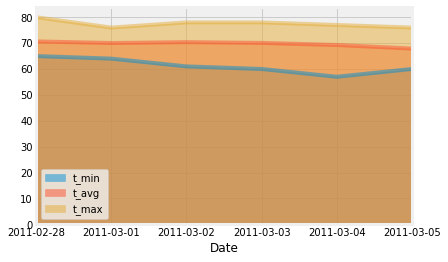

In [28]:
# Plot the daily normals as an area plot with `stacked=False`
trip_normals.plot.area(stacked=False)
plt.savefig("output/trip normals.png")